In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
!pip install pyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 1.7 MB/s eta 0:00:00a 0:00:01


In [2]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Lambda, SeparableConv2D, GlobalAvgPool2D, Input, Average, ReLU, Dropout, DepthwiseConv2D, Dense, GlobalAvgPool2D, GlobalAveragePooling2D,Conv2D, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, AvgPool2D, Concatenate, MaxPool2D
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU


from keras.preprocessing import image

from glob import glob

from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential,Model
import pandas as pd
# from keras.applications.resnet import ResNet50

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import time
import datetime
import os
import cv2
import io

# import imutils
import matplotlib.pyplot as plt
from os import listdir

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

2024-02-13 14:29:33.897914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 14:29:33.898053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 14:29:34.069714: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set the path to the dataset
# dataset_path = "C:/Users/USER/ML/Latest/def_data"
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Training")
test_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

1321
1339
1595
1457


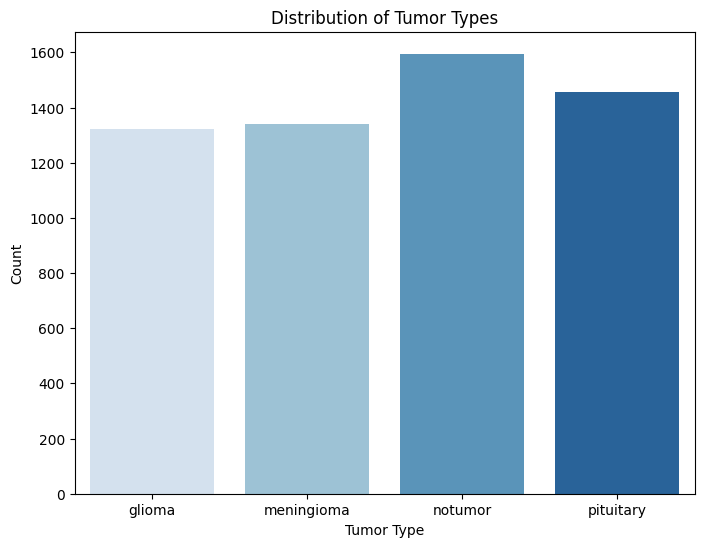

In [4]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    print(count)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count", palette = "Blues")#######, legend=False
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

300
306
405
300


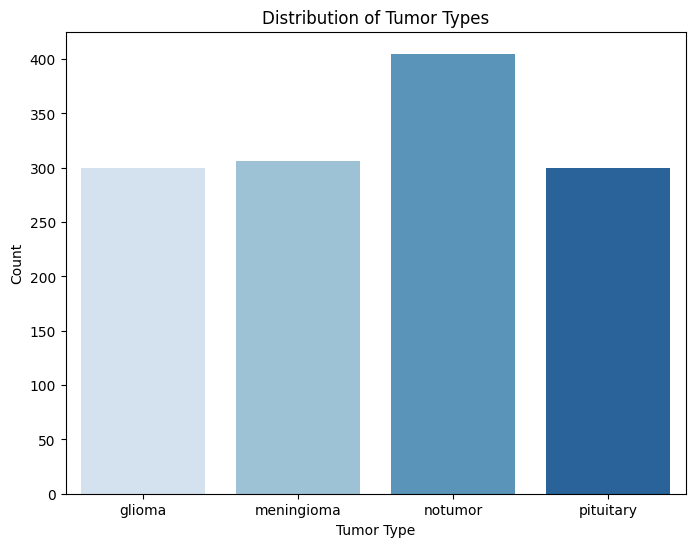

In [5]:
# Load and preprocess the dataset
test_data = []
for category in categories:
    folder_path = os.path.join(test_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    print(count)
    test_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

test_df = pd.concat(test_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=test_df, x="Category", y="Count", palette = "Blues")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

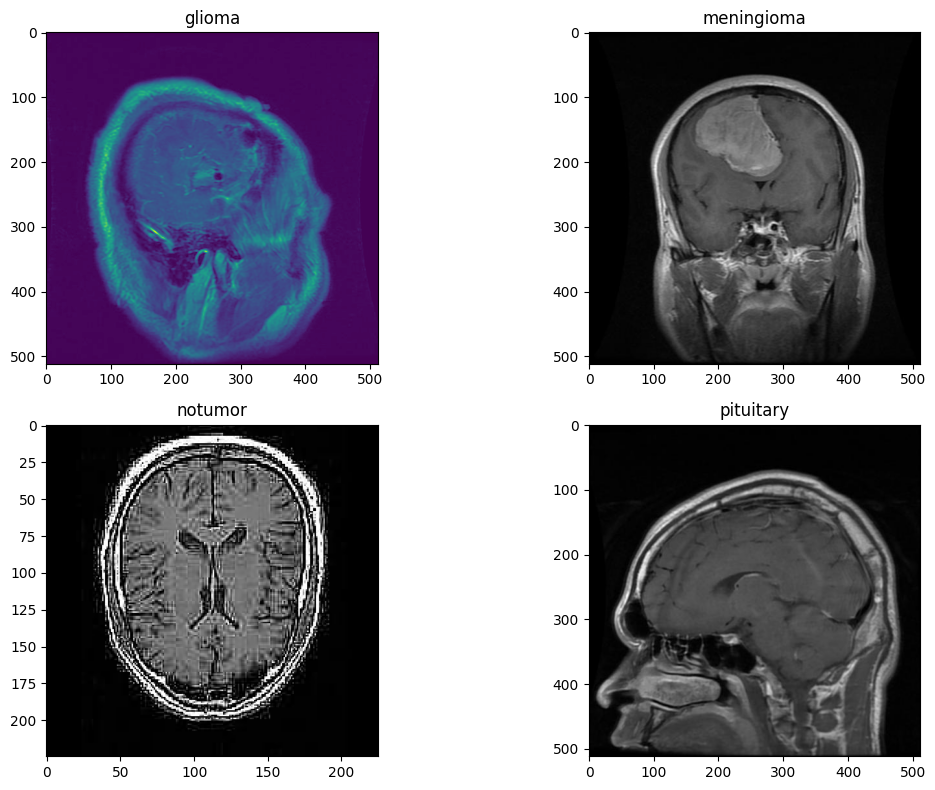

In [6]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("on")
plt.tight_layout()
plt.show()

In [7]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

In [8]:
# Data augmentation and preprocessing
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [10]:
def xception(input_shape, n_classes):

  def conv_bn(x, f, k, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


  def sep_bn(x, f, k, s=1, p='same'):
    x = SeparableConv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


  def entry_flow(x):
    x = conv_bn(x, 32, 3, 2)
    x = ReLU()(x)
    x = conv_bn(x, 64, 3)
    tensor = ReLU()(x)

    x = sep_bn(tensor, 128, 3)
    x = ReLU()(x)
    x = sep_bn(x, 128, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 128, 1, 2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 256, 1, 2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 728, 1, 2)
    x = Add()([tensor, x])

    return x


  def middle_flow(tensor):
    for _ in range(8):
      x = ReLU()(tensor)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)

      tensor = Add()([tensor, x])

    return tensor


  def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 1024, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 1024, 1, 2)

    x = Add()([tensor, x])
    x = sep_bn(x, 1536, 3)
    x = ReLU()(x)
    x = sep_bn(x, 2048, 3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(n_classes, activation='softmax')(x)

    return x


  input = Input(input_shape)

  x = entry_flow(input)
  x = middle_flow(x)
  output = exit_flow(x)

  model = Model(input, output)

  return model

In [11]:
IMG_SHAPE = (150, 150, 3)

In [12]:
xception_model = xception(IMG_SHAPE, 4)

In [14]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 75, 75, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 75, 75, 32)           0         ['batch_normalization[0][0

In [15]:
from keras.applications.inception_v3 import InceptionV3
InceptionV3 = InceptionV3(input_shape=(150, 150, 3),
            weights='imagenet',
            include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [16]:
for layer in InceptionV3.layers:
    layer.trainable = False

In [17]:
folders = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
print(len(folders))

4


In [18]:
x = InceptionV3.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)
InceptionV3_model = Model(inputs=InceptionV3.input, outputs=prediction)

In [19]:
InceptionV3_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_40 (Ba  (None, 74, 74, 32)           96        ['conv2d_6[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization_40

In [20]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='Ensemble_kaggke_Xception_InceptionV3.h5',
                             mode='max',
                             verbose=2,
                             save_best_only=True)
callbacks = [checkpoint]
start = datetime.now()

In [21]:
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# adam = keras.optimizers.Adam(learning_rate=0.001)
InceptionV3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Train the model
history_xception_model = xception_model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.samples // batch_size
)

Epoch 1/50


I0000 00:00:1707834683.584237     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 [==============================] - 123s 507ms/step - loss: 0.8966 - accuracy: 0.6530 - val_loss: 1.3618 - val_accuracy: 0.4187
Epoch 2/50
178/178 [==============================] - 50s 277ms/step - loss: 0.6644 - accuracy: 0.7451 - val_loss: 1.7026 - val_accuracy: 0.3570
Epoch 3/50
178/178 [==============================] - 50s 278ms/step - loss: 0.5012 - accuracy: 0.8114 - val_loss: 0.8926 - val_accuracy: 0.7242
Epoch 4/50
178/178 [==============================] - 50s 278ms/step - loss: 0.3933 - accuracy: 0.8558 - val_loss: 11.6162 - val_accuracy: 0.3562
Epoch 5/50
178/178 [==============================] - 49s 274ms/step - loss: 0.3090 - accuracy: 0.8879 - val_loss: 10.9106 - val_accuracy: 0.3906
Epoch 6/50
178/178 [==============================] - 50s 278ms/step - loss: 0.2836 - accuracy: 0.8961 - val_loss: 0.4647 - val_accuracy: 0.8313
Epoch 7/50
178/178 [==============================] - 49s 276ms/step - loss: 0.2516 - accuracy: 0.9141 - val_loss: 0.7064 - val_accuracy: 

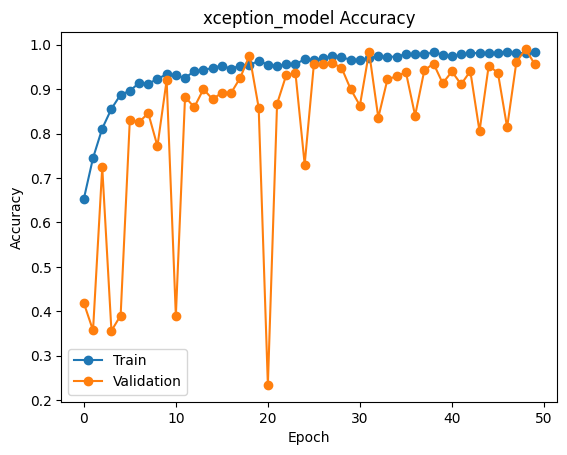

In [24]:
# Plot the training and validation accuracy over epochs
plt.plot(history_xception_model.history['accuracy'], '-o')
plt.plot(history_xception_model.history['val_accuracy'], '-o')
plt.title('xception_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

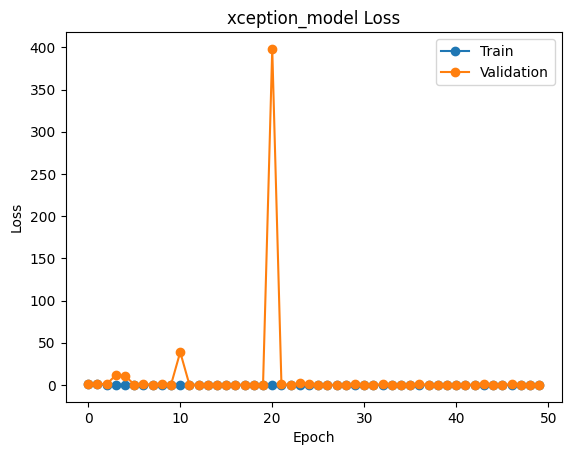

In [25]:
# Plot the training and validation loss over epochs
plt.plot(history_xception_model.history['loss'], '-o')
plt.plot(history_xception_model.history['val_loss'], '-o')
plt.title('xception_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [26]:
# Evaluate the model
loss_xception_model, accuracy_xception_model = xception_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("xception_model Test Loss:", loss_xception_model)
print("xception_model Test Accuracy:", accuracy_xception_model)

40/40 [==============================] - 3s 77ms/step - loss: 0.1287 - accuracy: 0.9563
xception_model Test Loss: 0.128668412566185
xception_model Test Accuracy: 0.956250011920929


41/41 [==============================] - 6s 118ms/step
[0 0 0 ... 3 3 3]


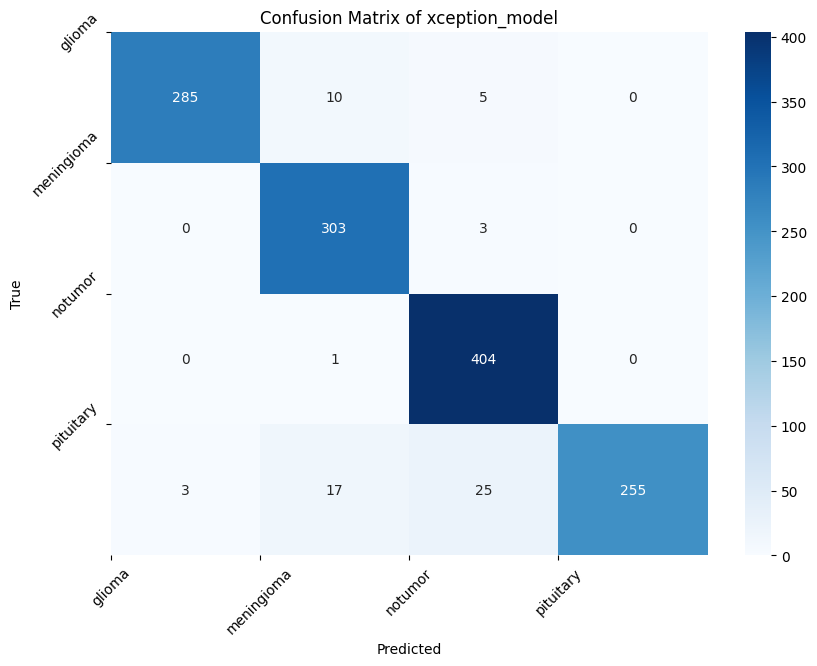

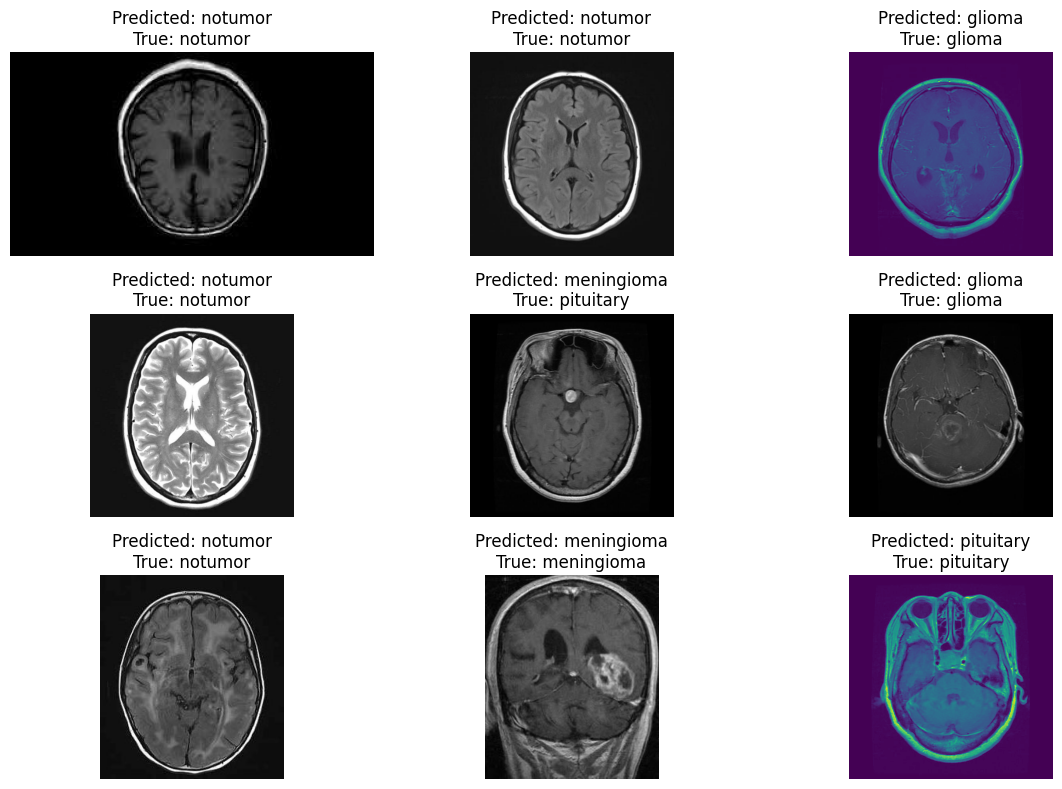

In [27]:
# Make predictions on the test dataset
predictions_xception_model = xception_model.predict(test_set)
predicted_categories_xception_model = np.argmax(predictions_xception_model, axis=1)

true_categories_xception_model = test_set.classes
print(true_categories_xception_model)

# Create a confusion matrix
confusion_matrix_xception_model = tf.math.confusion_matrix(true_categories_xception_model, predicted_categories_xception_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_xception_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of xception_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_xception_model = [categories[predicted_categories_xception_model[i]] for i in sample_indices]
sample_true_labels_xception_model = [categories[true_categories_xception_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_xception_model[i]}\nTrue: {sample_true_labels_xception_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.9895833333333334
Recall: 0.95
F1-Score: 0.9693877551020408

Class: meningioma
Precision: 0.9154078549848943
Recall: 0.9901960784313726
F1-Score: 0.9513343799058086

Class: notumor
Precision: 0.9244851258581236
Recall: 0.9975308641975309
F1-Score: 0.9596199524940618

Class: pituitary
Precision: 1.0
Recall: 0.85
F1-Score: 0.9189189189189189



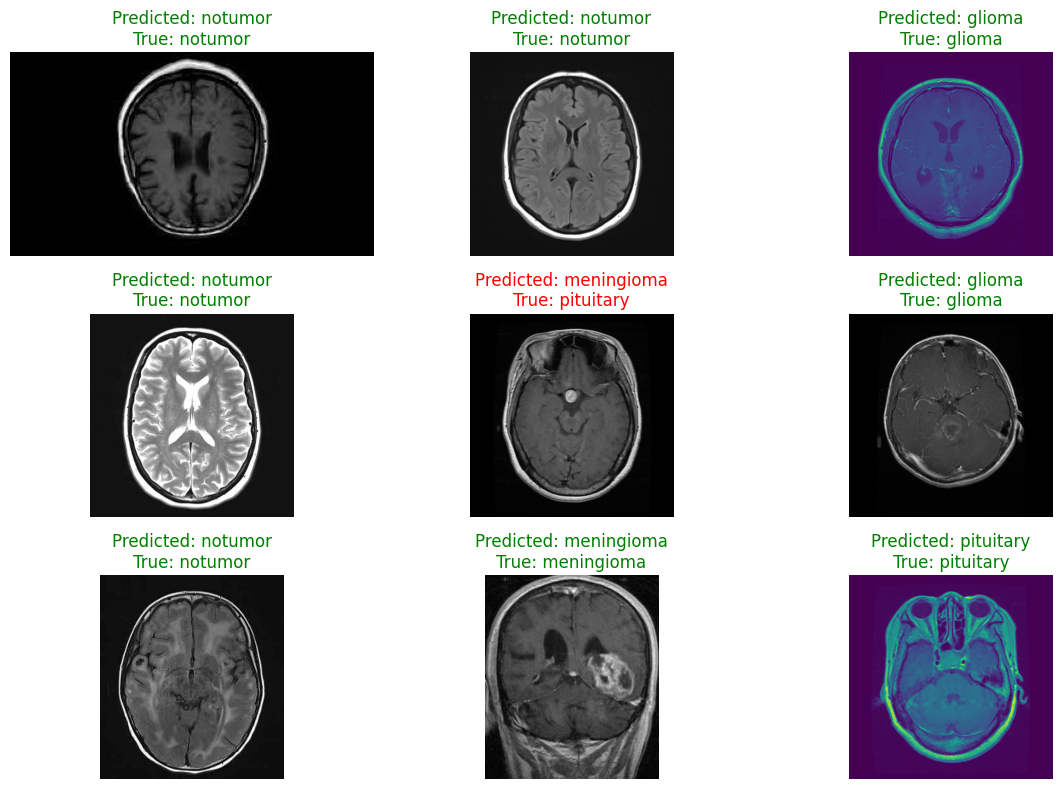

In [28]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_xception_model = np.diag(confusion_matrix_xception_model) / np.sum(confusion_matrix_xception_model, axis=0)
recall_xception_model = np.diag(confusion_matrix_xception_model) / np.sum(confusion_matrix_xception_model, axis=1)
f1_score_xception_model = 2 * (precision_xception_model * recall_xception_model) / (precision_xception_model + recall_xception_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_xception_model[i]}")
    print(f"Recall: {recall_xception_model[i]}")
    print(f"F1-Score: {f1_score_xception_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_xception_model[i] == sample_true_labels_xception_model[i]:
        plt.title(f"Predicted: {sample_predictions_xception_model[i]}\nTrue: {sample_true_labels_xception_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_xception_model[i]}\nTrue: {sample_true_labels_xception_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [29]:
# Save the trained model
xception_model.save("Xception_model_brain_tumor_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
# history = model.fit_generator(
history_InceptionV3_model = InceptionV3_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    steps_per_epoch=train_set.samples // batch_size,
    validation_steps=test_set.samples // batch_size,
    callbacks=callbacks,
    verbose=2)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50

Epoch 1: val_loss improved from -inf to 0.50683, saving model to Ensemble_kaggke_Xception_InceptionV3.h5
178/178 - 58s - loss: 0.8836 - accuracy: 0.7570 - val_loss: 0.5068 - val_accuracy: 0.8094 - 58s/epoch - 323ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.50683 to 0.52605, saving model to Ensemble_kaggke_Xception_InceptionV3.h5
178/178 - 48s - loss: 0.4793 - accuracy: 0.8151 - val_loss: 0.5260 - val_accuracy: 0.8055 - 48s/epoch - 268ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 0.52605
178/178 - 47s - loss: 0.4059 - accuracy: 0.8407 - val_loss: 0.5037 - val_accuracy: 0.8133 - 47s/epoch - 265ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 0.52605
178/178 - 47s - loss: 0.3915 - accuracy: 0.8519 - val_loss: 0.4011 - val_accuracy: 0.8492 - 47s/epoch - 262ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.52605 to 0.56598, saving model to Ensemble_kaggke_Xception_InceptionV3.h5
178/178 - 49s - loss: 0.3556 - accuracy: 0.8609 - val_loss: 0.566

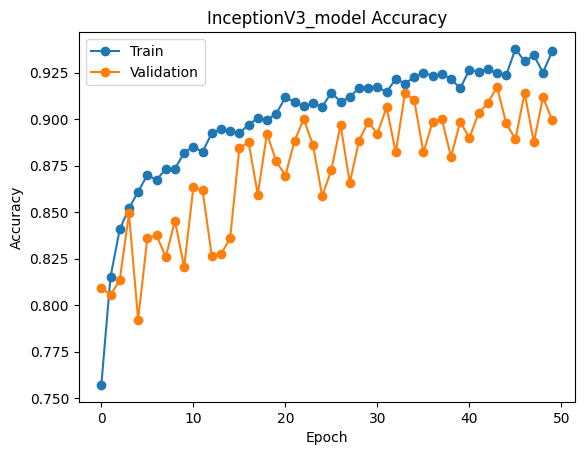

In [31]:
# Plot the training and validation accuracy over epochs
plt.plot(history_InceptionV3_model.history['accuracy'], '-o')
plt.plot(history_InceptionV3_model.history['val_accuracy'], '-o')
plt.title('InceptionV3_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

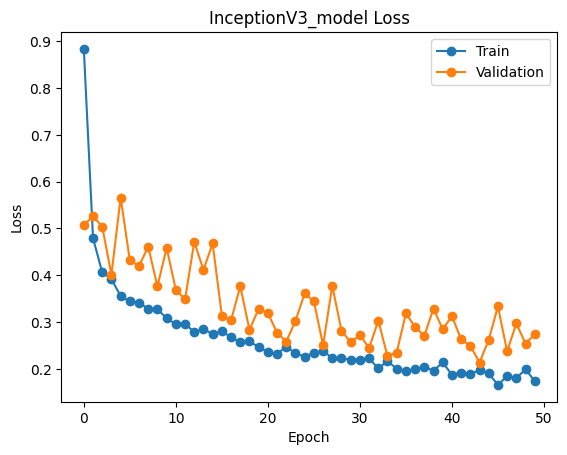

In [32]:
# Plot the training and validation loss over epochs
plt.plot(history_InceptionV3_model.history['loss'], '-o')
plt.plot(history_InceptionV3_model.history['val_loss'], '-o')
plt.title('InceptionV3_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [33]:
# Evaluate the model
loss_InceptionV3_model, accuracy_InceptionV3_model = InceptionV3_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("InceptionV3_model Test Loss:", loss_InceptionV3_model)
print("InceptionV3_model Test Accuracy:", accuracy_InceptionV3_model)

40/40 [==============================] - 3s 76ms/step - loss: 0.2736 - accuracy: 0.8992
InceptionV3_model Test Loss: 0.2736119031906128
InceptionV3_model Test Accuracy: 0.899218738079071


41/41 [==============================] - 7s 134ms/step
[0 0 0 ... 3 3 3]


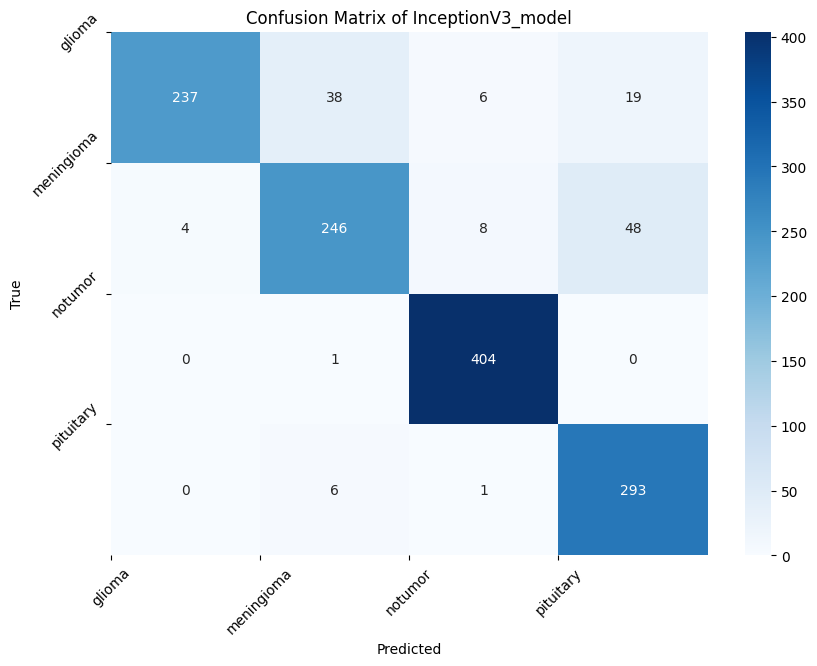

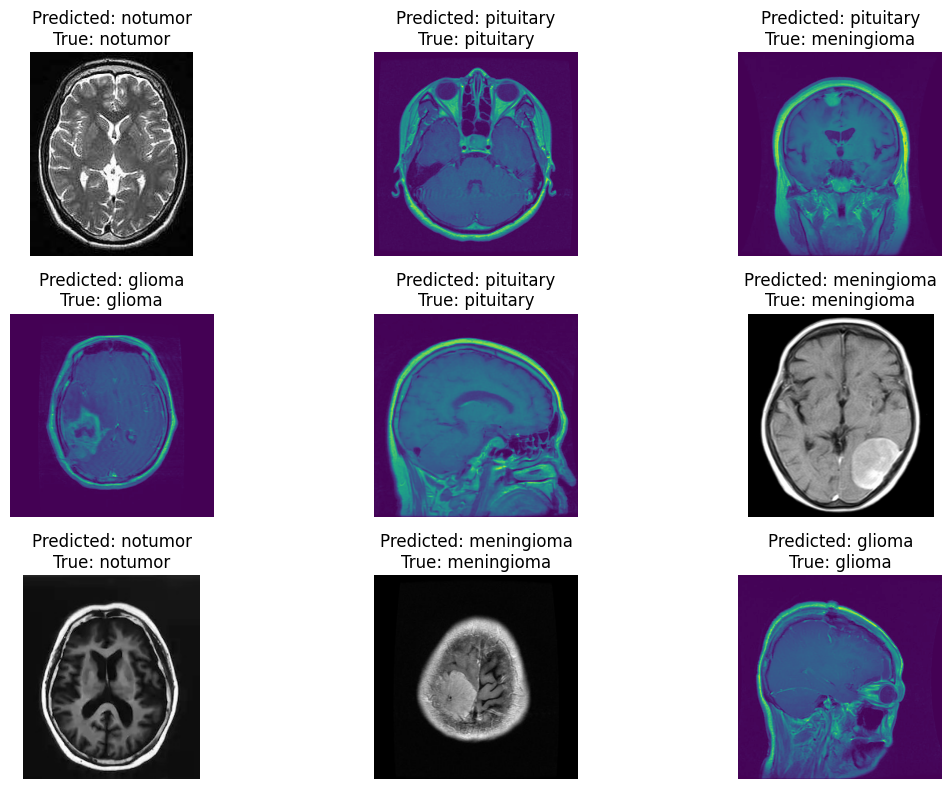

In [34]:
# Make predictions on the test dataset
predictions_InceptionV3_model = InceptionV3_model.predict(test_set)
predicted_categories_InceptionV3_model = np.argmax(predictions_InceptionV3_model, axis=1)

true_categories_InceptionV3_model = test_set.classes
print(true_categories_InceptionV3_model)

# Create a confusion matrix
confusion_matrix_InceptionV3_model = tf.math.confusion_matrix(true_categories_InceptionV3_model, predicted_categories_InceptionV3_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_InceptionV3_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of InceptionV3_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_InceptionV3_model = [categories[predicted_categories_InceptionV3_model[i]] for i in sample_indices]
sample_true_labels_InceptionV3_model = [categories[true_categories_InceptionV3_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.983402489626556
Recall: 0.79
F1-Score: 0.8761552680221811

Class: meningioma
Precision: 0.845360824742268
Recall: 0.803921568627451
F1-Score: 0.8241206030150755

Class: notumor
Precision: 0.964200477326969
Recall: 0.9975308641975309
F1-Score: 0.9805825242718447

Class: pituitary
Precision: 0.8138888888888889
Recall: 0.9766666666666667
F1-Score: 0.8878787878787878



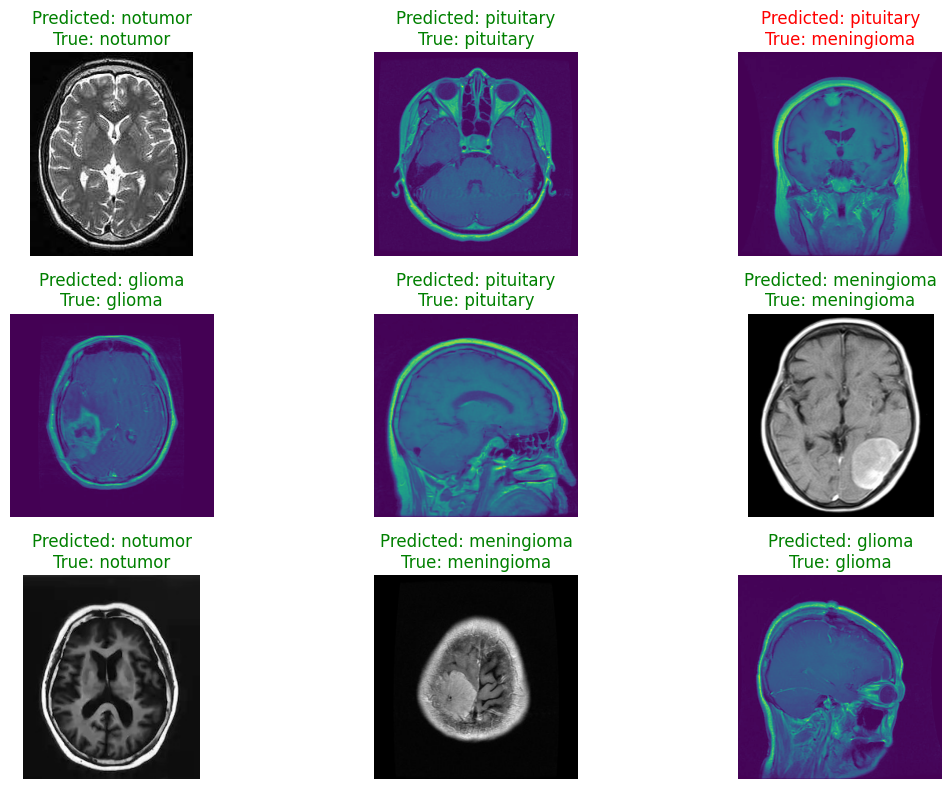

In [35]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_InceptionV3_model = np.diag(confusion_matrix_InceptionV3_model) / np.sum(confusion_matrix_InceptionV3_model, axis=0)
recall_InceptionV3_model = np.diag(confusion_matrix_InceptionV3_model) / np.sum(confusion_matrix_InceptionV3_model, axis=1)
f1_score_InceptionV3_model = 2 * (precision_InceptionV3_model * recall_InceptionV3_model) / (precision_InceptionV3_model + recall_InceptionV3_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_InceptionV3_model[i]}")
    print(f"Recall: {recall_InceptionV3_model[i]}")
    print(f"F1-Score: {f1_score_InceptionV3_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_InceptionV3_model[i] == sample_true_labels_InceptionV3_model[i]:
        plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [36]:
# Save the trained model
InceptionV3_model.save("InceptionV3_model_brain_tumor_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
xception_model = Model(inputs=xception_model.inputs,
                       outputs=xception_model.outputs,
                       name='xception_model')

InceptionV3_model = Model(inputs=InceptionV3_model.inputs,
                       outputs=InceptionV3_model.outputs,
                       name='InceptionV3_model')

In [38]:
models = [xception_model, InceptionV3_model]
model_input = Input(shape = (150, 150, 3))
model_outputs = [model(model_input) for model in models]
Ensamble_output = Average()(model_outputs)
Ensamble_model = Model(inputs=model_input, outputs=Ensamble_output, name='Ensamble_model')

In [39]:
Ensamble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
# Train the model
history_Ensamble_model = Ensamble_model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.samples // batch_size
)

Epoch 1/50
178/178 [==============================] - 81s 294ms/step - loss: 0.0823 - accuracy: 0.9824 - val_loss: 0.2356 - val_accuracy: 0.9211
Epoch 2/50
178/178 [==============================] - 51s 284ms/step - loss: 0.0879 - accuracy: 0.9806 - val_loss: 0.1655 - val_accuracy: 0.9477
Epoch 3/50
178/178 [==============================] - 52s 290ms/step - loss: 0.0981 - accuracy: 0.9794 - val_loss: 0.1362 - val_accuracy: 0.9570
Epoch 4/50
178/178 [==============================] - 51s 288ms/step - loss: 0.0818 - accuracy: 0.9820 - val_loss: 0.1291 - val_accuracy: 0.9594
Epoch 5/50
178/178 [==============================] - 52s 290ms/step - loss: 0.0686 - accuracy: 0.9884 - val_loss: 0.1923 - val_accuracy: 0.9219
Epoch 6/50
178/178 [==============================] - 51s 288ms/step - loss: 0.1135 - accuracy: 0.9739 - val_loss: 0.1573 - val_accuracy: 0.9594
Epoch 7/50
178/178 [==============================] - 51s 287ms/step - loss: 0.0790 - accuracy: 0.9840 - val_loss: 0.0957 - val_ac

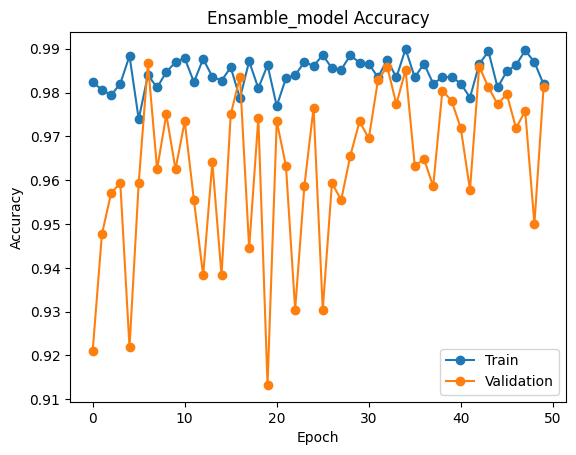

In [41]:
# Plot the training and validation accuracy over epochs
plt.plot(history_Ensamble_model.history['accuracy'], '-o')
plt.plot(history_Ensamble_model.history['val_accuracy'], '-o')
plt.title('Ensamble_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# axes = plt.axes()
# axes.set_ylim([0.9, 1])
plt.legend(['Train', 'Validation'])
plt.show()

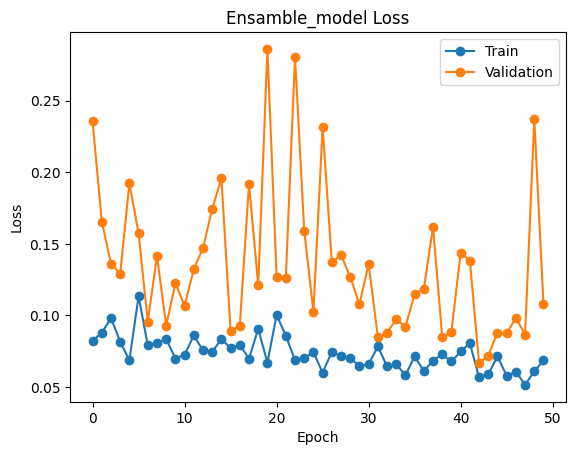

In [42]:
# Plot the training and validation loss over epochs
plt.plot(history_Ensamble_model.history['loss'], '-o')
plt.plot(history_Ensamble_model.history['val_loss'], '-o')
plt.title('Ensamble_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [43]:
# Evaluate the model
loss_Ensamble_model, accuracy_Ensamble_model = Ensamble_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("Ensamble_model Test Loss:", loss_Ensamble_model)
print("Ensamble_model Test Accuracy:", accuracy_Ensamble_model)

40/40 [==============================] - 4s 91ms/step - loss: 0.1077 - accuracy: 0.9812
Ensamble_model Test Loss: 0.1077120453119278
Ensamble_model Test Accuracy: 0.981249988079071


41/41 [==============================] - 6s 89ms/step
[0 0 0 ... 3 3 3]


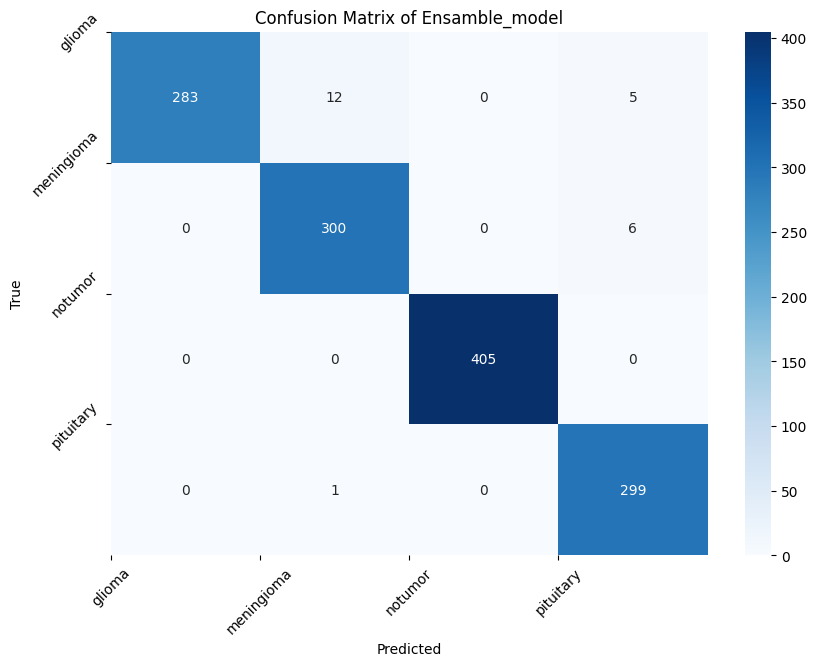

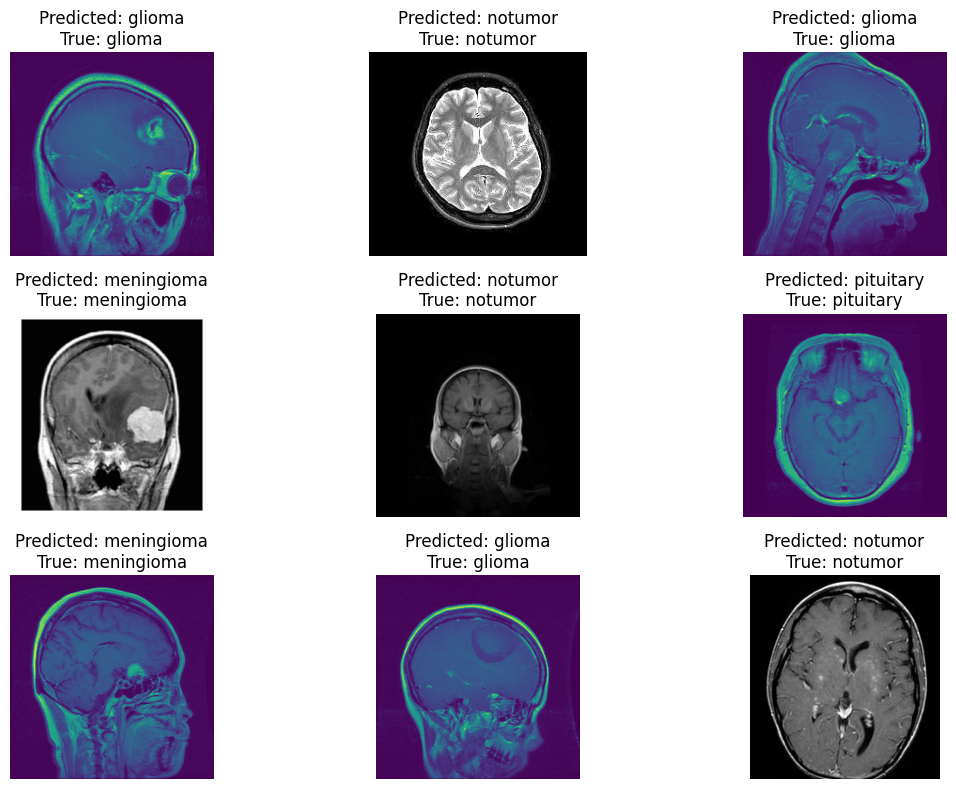

In [44]:
# Make predictions on the test dataset
predictions_Ensamble_model = Ensamble_model.predict(test_set)
predicted_categories_Ensamble_model = np.argmax(predictions_Ensamble_model, axis=1)

true_categories_Ensamble_model = test_set.classes
print(true_categories_Ensamble_model)

# Create a confusion matrix
confusion_matrix_Ensamble_model = tf.math.confusion_matrix(true_categories_Ensamble_model, predicted_categories_Ensamble_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_Ensamble_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of Ensamble_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_Ensamble_model = [categories[predicted_categories_Ensamble_model[i]] for i in sample_indices]
sample_true_labels_Ensamble_model = [categories[true_categories_Ensamble_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 1.0
Recall: 0.9433333333333334
F1-Score: 0.9708404802744426

Class: meningioma
Precision: 0.9584664536741214
Recall: 0.9803921568627451
F1-Score: 0.9693053311793214

Class: notumor
Precision: 1.0
Recall: 1.0
F1-Score: 1.0

Class: pituitary
Precision: 0.964516129032258
Recall: 0.9966666666666667
F1-Score: 0.980327868852459



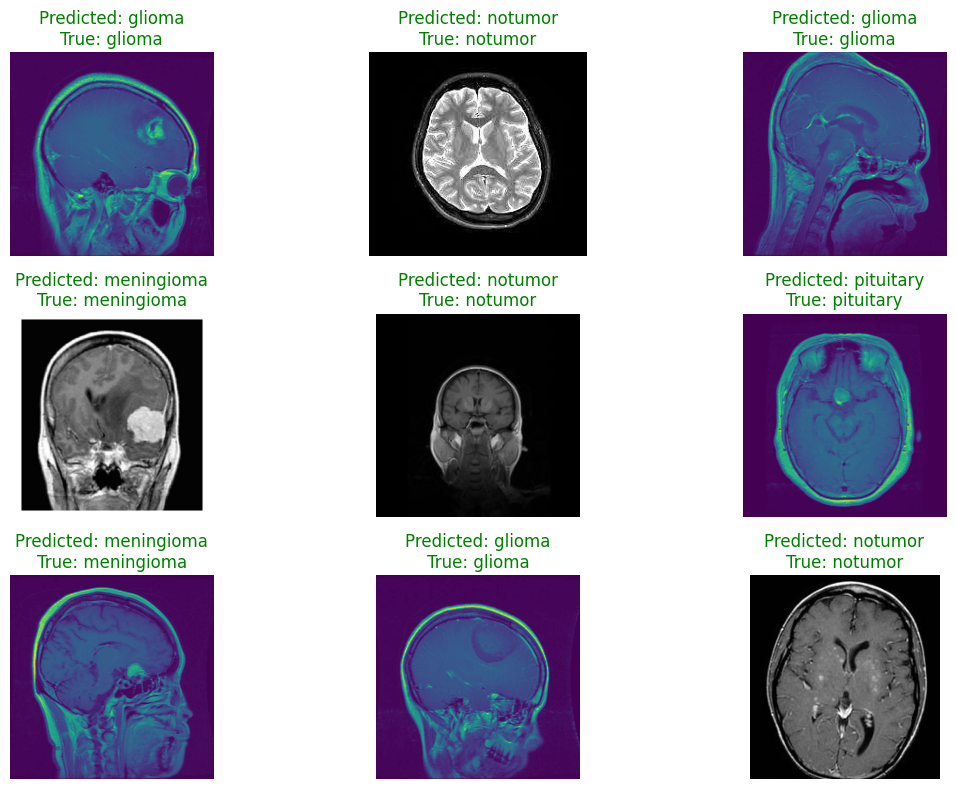

In [45]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_Ensamble_model = np.diag(confusion_matrix_Ensamble_model) / np.sum(confusion_matrix_Ensamble_model, axis=0)
recall_Ensamble_model = np.diag(confusion_matrix_Ensamble_model) / np.sum(confusion_matrix_Ensamble_model, axis=1)
f1_score_Ensamble_model = 2 * (precision_Ensamble_model * recall_Ensamble_model) / (precision_Ensamble_model + recall_Ensamble_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_Ensamble_model[i]}")
    print(f"Recall: {recall_Ensamble_model[i]}")
    print(f"F1-Score: {f1_score_Ensamble_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_Ensamble_model[i] == sample_true_labels_Ensamble_model[i]:
        plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [46]:
# Save the trained model
Ensamble_model.save("Ensamble_model_brain_tumor_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
